# **COVID-19-BERT-ResearchPapers-Semantic-Search**

This notebook will let us build a faster and accurate **CORD Search Engine** using Transformers - on top of the research articles provided as part of [Kaggle's competion CORD-19-research-challenge](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge). We would like to thank kaggle and all of the competion sponsers for this competion in bringing up efforts for fighting this virus.

In this notebook, we will: 
1.   First we sample 150000 documents from the cord dataset and structure them into `pandas.DataFrame for the ease of use. The preprocessed data can be found [here](https://drive.google.com/file/d/1zfmSzKA8riVF23nXlBp2lb_rpq21RSoE/view?usp=sharing).
2.   We used *'Retrieve & Re-Rank'* to find the relevant documents for a query.  
3.   Then we used *Longformer* model trained on squad to find the answer to the query.

**References** :

*   We used the library provided by [UKPLab](https://github.com/UKPLab) called [sentence-transformers](https://github.com/UKPLab/sentence-transformers) for this project. This library provides an easy method to compute dense vector representations for sentences, paragraphs, images and also has a lots of pretrained models.

*   Also used Huggingface 🤗 model hub for pretrained models.

## **Architecture**



We will follow an structure similar to **Open-domain Question Answering (ODQA)**  for this setup. 

It has 3 Major Components


**Retriever**: Fast, simple algorithm that identifies suitable candidate  from a large collection of documents. We have an asymmetric semantic search setup, where we have a short query and want to find a longer paragraph relevant to the query. We use DistilBert train on  MSMARCO Passage Ranking dataset for this purpose.


**Re-Ranker**: The retriever usually returns lots of candidate document to be efficient for a large collection. However, it might return irrelevant candidates. A re-ranker based on a Cross-Encoder substantially improve the final results for the user. The query and a possible document is passed simultaneously to transformer network, which then outputs a single score between 0 and 1 indicating how relevant the document is for the given query. 



**Reader**: Powerful neural model that reads through texts in detail to find an answer. The Reader takes set of reranked documents as input and returns top-n answers with corresponding confidence scores. Since we are dealing with large documents, *Longformer* trained on [SQuAD](https://rajpurkar.github.io/SQuAD-explorer/) dataset is our pick for the task. It is also fine-tuned on [Covid_QA](https://github.com/deepset-ai/COVID-QA) dataset and can be downloaded from [link](https://huggingface.co/abhijithneilabraham/longformer_covid_qa).





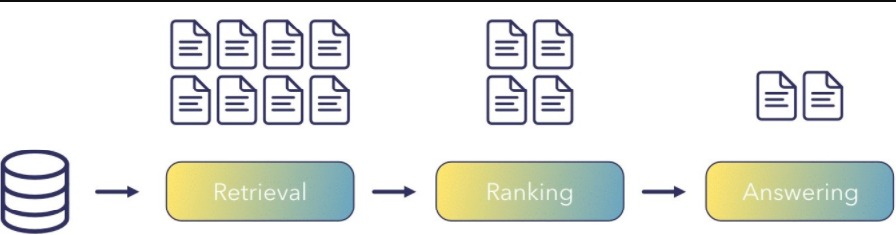



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# installing sentence transformer 

!pip install -U sentence-transformers

In [ ]:
# running on gpu
import torch
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('gpu')
torch.cuda.get_device_properties(0)

gpu


_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

In [ ]:
# importing required libraries

'''import json
import time
import gzip
import os'''

import torch
import warnings
import textwrap
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer, CrossEncoder, util

In [ ]:
warnings.filterwarnings("ignore")
wrapper = textwrap.TextWrapper(width = 200)

In [ ]:
# importing the csv from drive

cord_df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/cord_data.csv')
cord_df

,paper_id,title,abstract,full_text
0,7802613,Advances in 3D neuronal microphysiological sys...,NaN,Microphysiological systems MPS designed to stu...
1,7523559,Primary healthcare policy and vision for commu...,NaN,Primary care in the US is delivered by three m...
2,7347899,SARS-COV-2 Infection and Kawasaki Disease: Cas...,NaN,Covid19 infection is currently the most import...
3,7553566,Unintended consequences of COVID-19 safety mea...,NaN,The first case infected with the novel coronav...
4,7120939,"Epiglottitis, Acute Laryngitis, and Croup",NaN,"Epiglottitis, acute laryngitis, and croup are ..."
...,...,...,...,...
149994,c8b8c00,A Mathematical Model of Coronavirus Disease (C...,The research work in this paper attempts to de...,A mathematical model is a description of the w...
149995,2de2047,The effect of environmental diesel exhaust pol...,Diesel exhaust particles (DEP) are the major c...,Coronavirus disease 2019 is an acute pulmonary...
149996,b4fa05e,Abdominopelvic CT findings in patients with no...,Purpose Some patients with novel coronavirus d...,The novel coronavirus disease 2019 COVID2019 p...
149997,2525235,Expected and Unexpected Features of the Newly ...,Influenza A viruses (IAVs) are important zoono...,Influenza A viruses IAVs are important zoonoti...


In [ ]:
cord_df['length'] = cord_df['full_text'].apply(lambda x: len(x.split()))

(0.0, 15000.0)

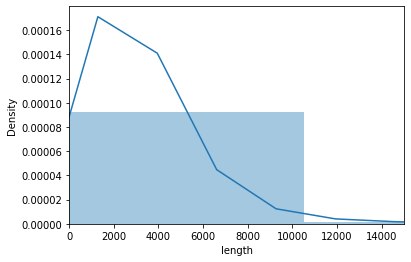

In [ ]:
# Distribution of document length. 
import seaborn as sns
ax = sns.distplot(cord_df['length'])
ax.set_xlim(0, 15000)

As evident from the plot, we are usually dealing with documents having words greater than 1000. So will use Longformer for extracting the answer from the text. We are using a pretrained model from Huggingface model hub.

In [ ]:
# creating a corpus of document text
corpus = cord_df['full_text'].tolist()
len(corpus)

149999

**Retrieve Rerank Answer**

We will use DistilBERT trained on MSMARCO dataset to embed all the documents into a dense representaion. The same model will be used to encode the query and will be compared with the dense vectors to retrieve the most suitable document sets.


![alt text](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/SemanticSearch.png)


In [ ]:
model_name = 'msmarco-distilbert-base-v3'
bi_encoder = SentenceTransformer(model_name)

# encoding documents
corpus_embeddings = bi_encoder.encode(corpus, convert_to_tensor=True, show_progress_bar=True) 


We use a cross-encoder also trained on MSMARCO Passage Ranking, to re-rank the  list of documents provided by the retriever to improve the quality of the result. This two stage retrieval system is better suited for large document collection.


In [ ]:
# using pretrained cross-encoder from sentence-transformer library
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [ ]:
# using pretrained longformer

import torch
from transformers import AutoTokenizer, AutoModelForQuestionAnswering

tokenizer = AutoTokenizer.from_pretrained("abhijithneilabraham/longformer_covid_qa", )
model = AutoModelForQuestionAnswering.from_pretrained("abhijithneilabraham/longformer_covid_qa",)
model.to(device)

In [ ]:
# method to find answer from a text

def find_answer(question, text):

  '''longformer usually quite resource hungry. So clearing gpu cache is a good idea. '''
  for i in range(0, 5):
    torch.cuda.empty_cache()

  answer = 0
  model.eval()
  with torch.no_grad():
    encoding = tokenizer(question, text, return_tensors="pt", max_length= 4096, truncation=True) 
    input_ids = encoding["input_ids"]

    # default is local attention everywhere
    # the forward method will automatically set global attention on question tokens
    attention_mask = encoding["attention_mask"]

    outputs = model(input_ids.cuda(), attention_mask=attention_mask.cuda())
    start_logits = outputs.start_logits
    end_logits = outputs.end_logits
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())


    answer_tokens = all_tokens[torch.argmax(start_logits) :torch.argmax(end_logits)+1]
    answer = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))
    if answer in tokenizer.all_special_tokens or answer== ' ' or '</s>' in answer or len(answer.split()) > 100:
      answer = ''
  return answer

In [ ]:
# Method to search
# top-k : Number of passages we want to retrieve with the bi-encoder
# max_counter : Max number of documents the reader must search for answer

def bienc_search(query, top_k=5, max_counter= 8):
  
  ##### Sematic Search #####
  #Encode the query using the bi-encoder and find potentially relevant docs
  question_embedding = bi_encoder.encode(query, convert_to_tensor=True)
  question_embedding = question_embedding.cuda()
  hits = util.semantic_search(question_embedding, corpus_embeddings, top_k=100)
  hits = hits[0]  # Get the hits for the first query

  ##### Re-Ranking #####
  #Now, score all retrieved docs with the cross_encoder
  cross_inp = [[query, corpus[hit['corpus_id']]] for hit in hits]
  cross_scores = cross_encoder.predict(cross_inp)

  #Sort results by the cross-encoder scores
  for idx in range(len(cross_scores)):
      hits[idx]['cross-score'] = cross_scores[idx]


  hits = sorted(hits, key=lambda x: x['cross-score'], reverse=True)
  
  max_counter = 0
  counter = 0
  for hit in hits:
      max_counter += 1      
      answer = find_answer(query, corpus[hit['corpus_id']])
      if counter > top_k or max_counter > 4:
          break 
      if answer != '':
        counter += 1
        print(f'Answer ====>> {wrapper.fill(answer)}')
        print('\n')
        print("Conf Score: {:.3f}".format(hit['cross-score']))
        print('Doc {}: \t {}'.format(counter, wrapper.fill(corpus[hit['corpus_id']][:1500])))
        print('='* 200)
        print('\n')

We're done!

Let's see, how well our search engine works!

As a response to our query - 
 - we get the `answer`
 - confidence score
 - a 1500 words `context` around the answer 


In [ ]:
query = "What is contact tracing in the context of the COVID-19 pandemic?"
bienc_search(query = query, top_k= 5)

Answer ====>>  a key mitigation strategy


Conf Score: 6.926
Doc 1: 	 In the context of the COVID19 pandemic, contact tracing is a key mitigation strategy. It is of paramount importance amongst health care personnel as they are a highrisk group 1, 2.We work in a busy
surgical department of a tertiary care centre in India. As part of the COVID19 infection control strategy, contact tracing amongst all healthcare workers was mandated at our institute and each
department has delegated the task to conduct contact tracing for any member who is symptomatic or positive for COVID19. Initially, we adopted the traditional Interview based contact tracing IBCT
which, we realised, had several disadvantages. IBCT took a significant amount of time, had no active motivation for healthcare workers to keep track of their contacts and other specific details, and
in the event of an actual positive case being identified, a recall could be affected by psychological factors like anxiety and stress 3, 4. These